# 1D case - Figure 5: minimal tensor decomposition
Mono-parameter 1D problem - Investigation of  the  convergence  of  the  reduced-order model and of the evolution of the size of the reduced-order basis.

## Libraries import  

In [1]:

import sys  
import torch
import torch.nn as nn
from neurom.HiDeNN_PDE import MeshNN, NeuROM, MeshNN_2D, MeshNN_1D
import neurom.src.Pre_processing as pre
from neurom.src.PDE_Library import Strain, Stress,VonMises_plain_strain
from neurom.src.Training import Training_NeuROM_multi_level
import neurom.Post.Plots as Pplot
import time
import os
import torch._dynamo as dynamo
from importlib import reload  
import tomllib
import numpy as np
import argparse

torch.manual_seed(0)

* WARNING: could not load tikzplotlib


## Load the config file

In [2]:
    Configuration_file = 'Configurations/config_1D_ROM_5.toml'

    with open(Configuration_file, mode="rb") as file:
        config = tomllib.load(file)

## Definition of the space domain and mechanical proprieties of the structure

The initial material parameters, the geometry, mesh and the boundary conditions are set. 

In [3]:

# Material parameters definition

Mat = pre.Material(             flag_lame = True,                                   # If True should input lmbda and mu instead of E and nu
                                coef1     = config["material"]["E"],                # Young Modulus
                                coef2     = config["geometry"]["A"]                 # Section area of the 1D bar
                    )


# Create mesh object
MaxElemSize = pre.ElementSize(
                                dimension     = config["interpolation"]["dimension"],
                                L             = config["geometry"]["L"],
                                order         = config["interpolation"]["order"],
                                np            = config["interpolation"]["np"],
                                MaxElemSize2D = config["interpolation"]["MaxElemSize2D"]
                            )
Excluded = []
Mesh_object = pre.Mesh( 
                                config["geometry"]["Name"],                         # Create the mesh object
                                MaxElemSize, 
                                config["interpolation"]["order"], 
                                config["interpolation"]["dimension"]
                        )

Mesh_object.AddBorders(config["Borders"]["Borders"])
Mesh_object.AddBCs(                                                                 # Include Boundary physical domains infos (BCs+volume)
                                config["geometry"]["Volume_element"],
                                Excluded,
                                config["DirichletDictionryList"]
                    )                   

Mesh_object.MeshGeo()                                                               # Mesh the .geo file if .msh does not exist
Mesh_object.ReadMesh()       
Mesh_object.AssemblyMatrix() 

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  3.1.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Dofs:           30


## Parametric study definition

The hypercube describing the parametric domain used for the tensor decomposition is set-up here

In [4]:
ParameterHypercube = torch.tensor([ [   config["parameters"]["para_1_min"],
                                        config["parameters"]["para_1_max"],
                                        config["parameters"]["N_para_1"]]])

## Initialisation of the surrogate model

In [5]:
ROM_model = NeuROM(                                                                 # Build the surrogate (reduced-order) model
                    Mesh_object, 
                    ParameterHypercube, 
                    config,
                    config["solver"]["n_modes_ini"],
                    config["solver"]["n_modes_max"]
                    )

## Training the model

In [6]:
ROM_model.Freeze_Mesh()                                                             # Set space mesh coordinates as untrainable
ROM_model.Freeze_MeshPara()                                                         # Set parameters mesh coordinates as untrainable

ROM_model.TrainingParameters(   
                                loss_decrease_c = config["training"]["loss_decrease_c"], 
                                Max_epochs = config["training"]["n_epochs"], 
                                learning_rate = config["training"]["learning_rate"]
                            )

ROM_model.train()                                                                   # Put the model in training mode
if config["training"]["multiscl_max_refinment"] == 1:
    ROM_model = Training_NeuROM_multi_level(ROM_model,config, Mat)  
else:
    ROM_model, Mesh_object = Training_NeuROM_multi_level(ROM_model,config, Mat)  

* Refinement level: 0

**************** START TRAINING ***************



epoch 100 loss = 8.20034e-03 error = 1.1571e+02% modes = 1
epoch 200 loss = -6.28895e-03 error = 1.0359e+02% modes = 1
epoch 300 loss = -1.86481e-02 error = 5.1432e+01% modes = 1
epoch 400 loss = -2.56568e-02 error = 2.8800e+01% modes = 1
epoch 500 loss = -2.98691e-02 error = 1.7452e+01% modes = 1
epoch 600 loss = -3.23983e-02 error = 1.1177e+01% modes = 1
epoch 700 loss = -3.38277e-02 error = 8.2473e+00% modes = 1
epoch 800 loss = -3.45264e-02 error = 7.2308e+00% modes = 1
epoch 900 loss = -3.48065e-02 error = 6.9681e+00% modes = 1
epoch 1000 loss = -3.48987e-02 error = 6.9153e+00% modes = 1
*************** END FIRST PHASE ***************

* Training time: 4.273508071899414s
* Saving time: 7.152557373046875e-07s
* Evaluation time: 2.0140490531921387s
* Backward time: 1.1272306442260742s
* Update time: 0.1645209789276123s
* Average epoch time: 0.0039606191583868525s
************** START SECOND PAHSE *************

epoch 5 loss = -3.4935e-02 error = 6.9229e+00%
*************** END OF TR

## Plotting area

Reproducing figure 5, a-b-c

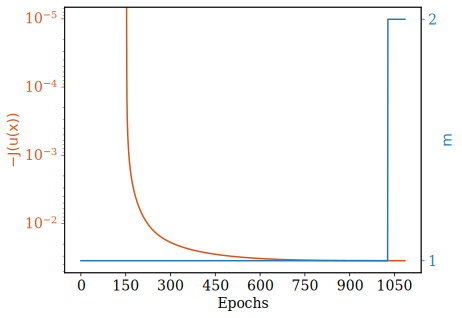

<Figure size 640x480 with 0 Axes>

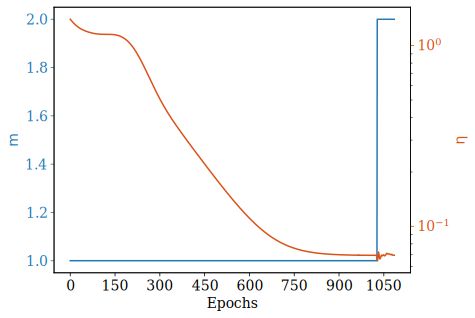

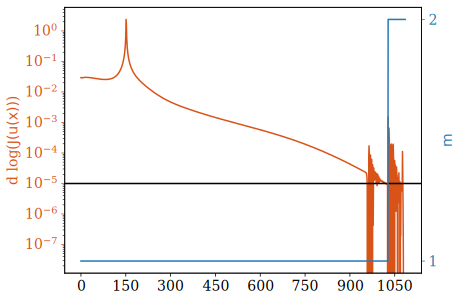

<Figure size 640x480 with 0 Axes>

In [7]:
tikz = False

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib
plt.rcParams['text.usetex'] = False

Modes_flag = ROM_model.training_recap["Mode_vect"]
loss_training = ROM_model.training_recap["Loss_vect"]
decay = ROM_model.training_recap["Loss_decrease_vect"]
threshold = config["training"]["loss_decrease_c"]
error = ROM_model.training_recap["L2_error"]
name = 'Fig5a'


# plot Fig 5a

fig = plt.figure()
ax = fig.add_subplot(111)

## First curve
ax.invert_yaxis()
g1 = ax.semilogy(-torch.tensor(loss_training), color='#d95319ff')
ax.set_ylabel(r'$ - J\left(u\left(x\right)\right)$',color='#d95319ff')
ax.tick_params(axis='y', colors='#d95319ff', which='both')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel(r'Epochs')

## Second curve
ax2 = ax.twinx()
g2 = ax2.plot(Modes_flag, color='#247ab5ff')
ax2.set_ylabel(r'$m$',color='#247ab5ff')
ax2.tick_params(axis='y', colors='#247ab5ff')
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

if tikz:
    import tikzplotlib
    tikzplotlib.save('Results/'+name+'_zoom.tex')
plt.savefig('Results/'+name+'_zoom.pdf', transparent=True, bbox_inches = "tight")

plt.show() 
plt.clf() 





name = 'Fig5b'

fig = plt.figure()
ax = fig.add_subplot(111)
g1 = ax.plot(Modes_flag, color='#247ab5ff')
ax.tick_params(axis='y', colors='#247ab5ff')
plt.ylabel(r'$m$',color='#247ab5ff')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Epochs')
ax2 = ax.twinx()

g2 = ax2.semilogy(torch.tensor(error), color='#d95319ff')
ax2.set_ylabel(r'$\eta$',color='#d95319ff')

ax2.tick_params(axis='y', colors='#d95319ff')

lns = g1+g2
labs = [l.get_label() for l in lns]
# ax.legend(lns, labs, loc="upper center")
if tikz:
    import tikzplotlib
    tikzplotlib.save('Results/'+name+'.tex')
plt.savefig('Results/'+name+'.pdf', transparent=True, bbox_inches = "tight")

plt.show() 

plt.clf() 


name = 'Fig5c'

# plot Fig 15c

ax = plt.gca()
ax.semilogy(decay,color='#d95319ff')
ax.tick_params(axis='y', colors='#d95319ff')
ax.set_ylabel(r'd log($J\left(u\left(x\right)\right)$)',color='#d95319ff')
plt.axhline(threshold,color = 'k')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))


# plt.ylim((0.01,20))
ax2 = plt.gca().twinx()
ax2.plot(Modes_flag,color='#247ab5ff')
ax2.set_ylabel(r'$m$',color='#247ab5ff')
ax2.tick_params(axis='y', colors='#247ab5ff')
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

if tikz:
    import tikzplotlib
    tikzplotlib.save('Results/'+name+'.tex')
plt.savefig('Results/'+name+'.pdf', transparent=True, bbox_inches = "tight")
plt.show() 

plt.clf()

In [26]:
import pandas as pd
epochs = list(range(len(Modes_flag)))
N = len(decay)
Name = "Fig5"
data = np.stack((epochs[:N],decay[:N],Modes_flag[:N],error[:N],(-torch.tensor(loss_training)[:N]).tolist()),axis=1)
df = pd.DataFrame(data, columns=['epochs', 'Decay','Modes', "Error","Loss"])
df.to_csv('Results/'+Name+'.csv')